In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

In [2]:
def filter1(image, median_size=3, gaussian_sigma=1):
    image = cv2.medianBlur(image, median_size)
    image = cv2.GaussianBlur(image, (0, 0), gaussian_sigma)
    return image

def filter2(image, median_size=3):
    image = cv2.medianBlur(image, median_size)
    image = cv2.bilateralFilter(image, 9, 75, 75)
    return image

def filter3(image, median_size=3):
    image = cv2.medianBlur(image, median_size)
    image = cv2.fastNlMeansDenoisingColored(image)
    return image

In [11]:
# Splits the given rect in 4 rect if there are at least k points inside 
def split_rect(rect, points, k=5, max_depth=5):
    # Rect is a tuple of 4 points
    # rect = (upper_right, upper_left, lower_left, lower_right)
    max_depth -= 1
    if max_depth == 0:
        return []
    rects = []
    
    y_min, y_max = rect[3][1], rect[0][1]
    x_min, x_max = rect[1][0], rect[0][0]
    y_med, x_med = (y_max + y_min)/2, (x_max + x_min)/2
    
    inside_points = [p for p in points if p[0] >= x_min and p[0] <= x_max and p[1] >= y_min and p[1] <= y_max]
    if len(inside_points) == 0:
        return None
    
    if len(inside_points) > k:
        upper_right_rect = ((x_max, y_max), (x_med, y_max), (x_med, y_med), (x_max, y_med))
        upper_left_rect = ((x_med, y_max), (x_min, y_max), (x_min, y_med), (x_med, y_med))
        lower_left_rect = ((x_med, y_med), (x_min, y_med), (x_min, y_min), (x_med, y_min))
        lower_right_rect = ((x_max, y_med), (x_med, y_med), (x_med, y_min), ((x_max, y_min)))
                
        upper_right_split = split_rect(upper_right_rect, points, k, max_depth)
        upper_left_split = split_rect(upper_left_rect, points, k, max_depth)
        lower_left_split = split_rect(lower_left_rect, points, k, max_depth)
        lower_right_split = split_rect(lower_right_rect, points, k, max_depth)
        
        if upper_right_split is not None:
            if len(upper_right_split) > 0:
                rects += upper_right_split
            else:
                rects += [upper_right_rect]
            
        if upper_left_split is not None:
            if len(upper_left_split) > 0:
                rects += upper_left_split
            else:
                rects += [upper_left_rect]
            
        if lower_left_split is not None:
            if len(lower_left_split) > 0:
                rects += lower_left_split
            else:
                rects += [lower_left_rect]
            
        if lower_right_split is not None:
            if len(lower_right_split) > 0:
                rects += lower_right_split
            else:
                rects += [lower_right_rect]
         
            
    return rects

In [4]:
def getDensity(matched_kp:list[tuple[float, float]], template_partition:list):
    match_count = { s: 0 for s in template_partition }
    
    for x_kp, y_kp in matched_kp:
        for section in template_partition:
            (x_max, y_max), (_, _), (x_min, y_min), (_, _) = section
            if (x_min <= x_kp <= x_max) and (y_min <= y_kp <= y_max):
                match_count[section] += 1

    return [s for s in template_partition if match_count[s] > 0]
    # return sum([1 for s in template_partition if match_count[s] > 0]) / len(template_partition)

In [5]:
template = cv2.imread("./dataset/models/ref6.png")
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)

scene = cv2.imread("./dataset/scenes/scene3.png")
# scene = cv2.imread("./dataset/models/ref8.png")
scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
scene = filter2(scene)

In [6]:
# sift = cv2.xfeatures2d.SIFT_create()
sift = cv2.SIFT_create()

kp_template = sift.detect(template)
kp_template, desc_template = sift.compute(template, kp_template)

kp_scene = sift.detect(scene)
kp_scene, desc_scene = sift.compute(scene, kp_scene)


FLANN_INDEX_KDTREE = 1

flann = cv2.FlannBasedMatcher(
    indexParams = { "algorithm": FLANN_INDEX_KDTREE, "trees": 5 },
    searchParams = { "checks": 50 }
)
matches = flann.knnMatch(desc_template, desc_scene, k=2)
good_matches = [ m for m, n in matches if m.distance < 0.7*n.distance ]

template_pts = np.float32([ kp_template[m.queryIdx].pt for m in good_matches ]).reshape(-1, 2)
scene_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good_matches ]).reshape(-1, 2)

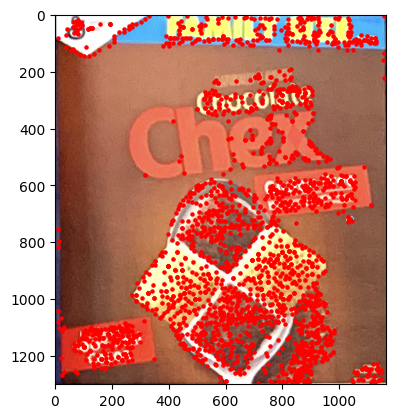

In [7]:
plt.imshow(template)
plt.scatter([k.pt[0] for k in kp_template], [k.pt[1] for k in kp_template], c="r", s=5)

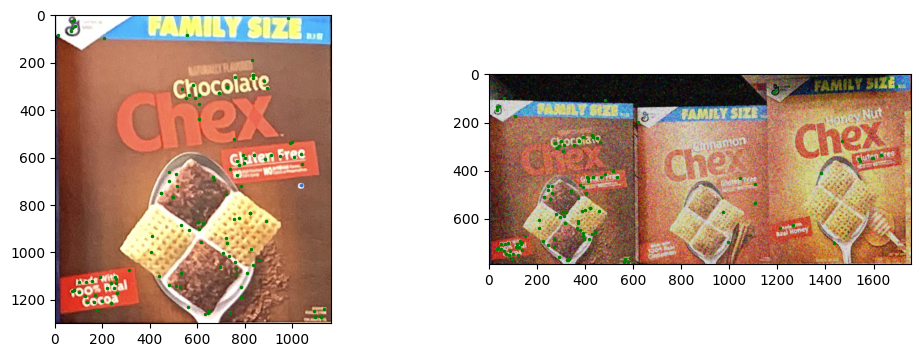

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(template)
plt.plot(template_pts[:, 0], template_pts[:, 1], "g.", markersize=3)

plt.subplot(1, 2, 2)
plt.imshow(scene)
plt.plot(scene_pts[:, 0], scene_pts[:, 1], "g.", markersize=3)
plt.show()

In [14]:
w, h, _ = template.shape
rects = split_rect(
    ( (h, w), (0, w), (0, 0), (h, 0) ),
    [ (kp.pt[0], kp.pt[1]) for kp in kp_template ],
    k = 5,
    max_depth = 4
)

match_rects = getDensity(template_pts, rects)

print(f"Confidence: {len(match_rects) / len(rects)}")

Confidence: 0.5789473684210527


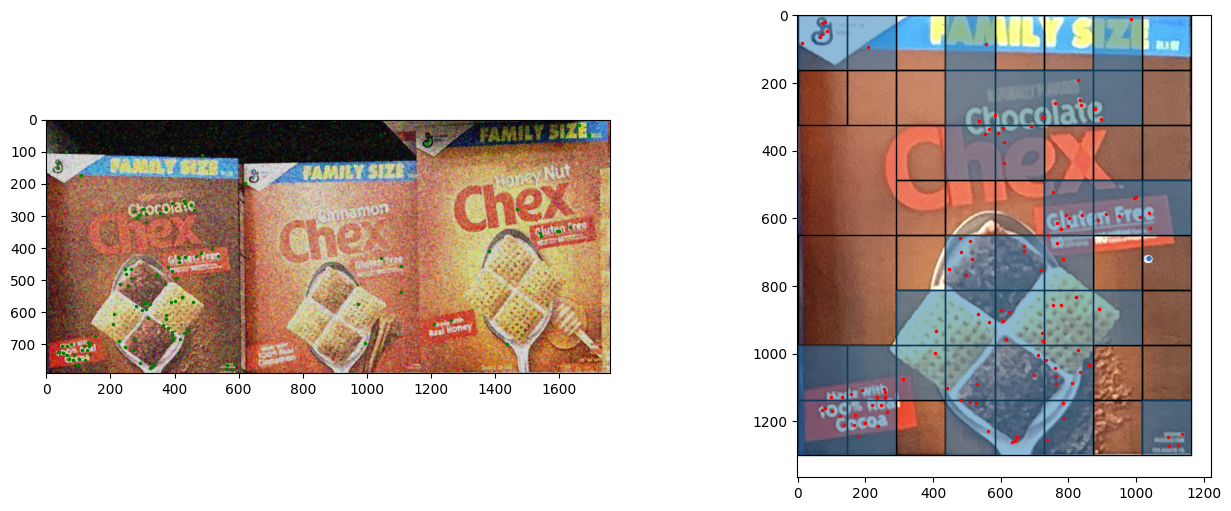

In [15]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(scene)
plt.plot(scene_pts[:, 0], scene_pts[:, 1], "g.", markersize=3)

ax = plt.subplot(1, 2, 2)
ax.imshow(template)
# ax.plot([kp.pt[0] for kp in kp_template], [kp.pt[1] for kp in kp_template], ".")
ax.plot([kp[0] for kp in template_pts], [kp[1] for kp in template_pts], "r.", markersize=3)
for r in rects:
    ax.add_patch(Rectangle(r[2], r[0][0] - r[1][0], r[0][1] - r[3][1], fill=False))
for r in match_rects:
    ax.add_patch(Rectangle(r[2], r[0][0] - r[1][0], r[0][1] - r[3][1], fill=True, alpha=0.5))

plt.show()

In [11]:
def get_confidence_match(template, scene, kk=[5], max_depths=[5]):
    sift = cv2.SIFT_create()

    kp_template = sift.detect(template)
    kp_template, desc_template = sift.compute(template, kp_template)

    kp_scene = sift.detect(scene)
    kp_scene, desc_scene = sift.compute(scene, kp_scene)


    FLANN_INDEX_KDTREE = 1

    flann = cv2.FlannBasedMatcher(
        indexParams = { "algorithm": FLANN_INDEX_KDTREE, "trees": 5 },
        searchParams = { "checks": 50 }
    )
    matches = flann.knnMatch(desc_template, desc_scene, k=2)
    good_matches = [ m for m, n in matches if m.distance < 0.7*n.distance ]

    template_pts = np.float32([ kp_template[m.queryIdx].pt for m in good_matches ]).reshape(-1, 2)
    scene_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good_matches ]).reshape(-1, 2)
    
    w, h, _ = template.shape
    
    
    results = np.zeros((len(kk), len(max_depths)))
    for i,k in enumerate(kk):
        for j,max_depth in enumerate(max_depths):
            rects = split_rect(
                ( (h, w), (0, w), (0, 0), (h, 0) ),
                [ (kp.pt[0], kp.pt[1]) for kp in kp_template ],
                k = k,
                max_depth = max_depth
            )

            match_rects = getDensity(template_pts, rects)
    
            res = len(match_rects) / len(rects)
            
            results[i,j] = res
    
    return results
    # print(f"Confidence: {len(match_rects) / len(rects)}")

In [12]:
template = cv2.imread("./dataset/models/ref1.png")
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)

scene = cv2.imread("./dataset/scenes/scene1.png")
scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
scene = filter1(scene)

In [13]:
get_confidence_match(template, scene, kk=[4], max_depths=[4])

array([[0.828125]])

In [ ]:
from tqdm import tqdm

model_scenes_ground_truth = {
    "ref1" : ["scene1", "scene4"],
    "ref2" : ["scene1"],
    "ref3" : ["scene2"],
    "ref4" : ["scene2"],
    "ref5" : ["scene2"],
    "ref6" : ["scene3"],
    "ref7" : ["scene3", "scene4"]
}

all_scenes = [f"scene{i}" for i in range(1, 8)]
all_templates = [f"ref{i}" for i in range(1, 8)]

# Read all the scenes and all the templates
scenes = { s : cv2.imread(f"./dataset/scenes/{s}.png") for s in all_scenes }
templates = { t : cv2.imread(f"./dataset/models/{t}.png") for t in all_templates }

# Filter the scenes
scenes = { s : filter1(scenes[s]) for s in scenes }

# Get the confidence with different values for k and depth
kk = np.arange(2, 7)
depths = np.arange(2, 7)
confidences_correct = np.zeros((len(kk), len(depths), len(all_templates), len(all_scenes)))
confidences_wrong = np.zeros((len(kk), len(depths), len(all_templates), len(all_scenes)))

# For each pair scene-template
for t in all_templates:
    for s in tqdm(all_scenes):
        # Get the confidence
        confidence = get_confidence_match(templates[t], scenes[s], kk=kk, max_depths=depths)
        # If the scene is in the ground truth
        for i in range(len(kk)):
            for j in range(len(depths)):
                if s in model_scenes_ground_truth[t]:
                    confidences_correct[i, j, all_templates.index(t), all_scenes.index(s)] = confidence[i, j]
                else:
                    confidences_wrong[i, j, all_templates.index(t), all_scenes.index(s)] = confidence[i, j]

100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


When using our method we have to choose 3 parameters

- $k$: the small rectangles are splitted only if there are more than $k$ points inside them.
- $max\_depth$: the small rectangles are splitted at a specified $max\_depth$ (recursive algorithm).
- $t$: the threshold used to choose if a given match is correct.

We first calculate the percentage of the rectangles that contains at least one matched point and if this number is above $t$, then the match is found.

([<matplotlib.axis.XTick at 0x277dad78df0>,
 [Text(0.0, 0, '0.00'),
  Text(0.05, 0, '0.05'),
  Text(0.1, 0, '0.10'),
  Text(0.15000000000000002, 0, '0.15'),
  Text(0.2, 0, '0.20'),
  Text(0.25, 0, '0.25'),
  Text(0.30000000000000004, 0, '0.30'),
  Text(0.35000000000000003, 0, '0.35'),
  Text(0.4, 0, '0.40'),
  Text(0.45, 0, '0.45'),
  Text(0.5, 0, '0.50'),
  Text(0.55, 0, '0.55'),
  Text(0.6000000000000001, 0, '0.60'),
  Text(0.65, 0, '0.65'),
  Text(0.7000000000000001, 0, '0.70'),
  Text(0.75, 0, '0.75'),
  Text(0.8, 0, '0.80'),
  Text(0.8500000000000001, 0, '0.85'),
  Text(0.9, 0, '0.90'),
  Text(0.9500000000000001, 0, '0.95'),
  Text(1.0, 0, '1.00')])

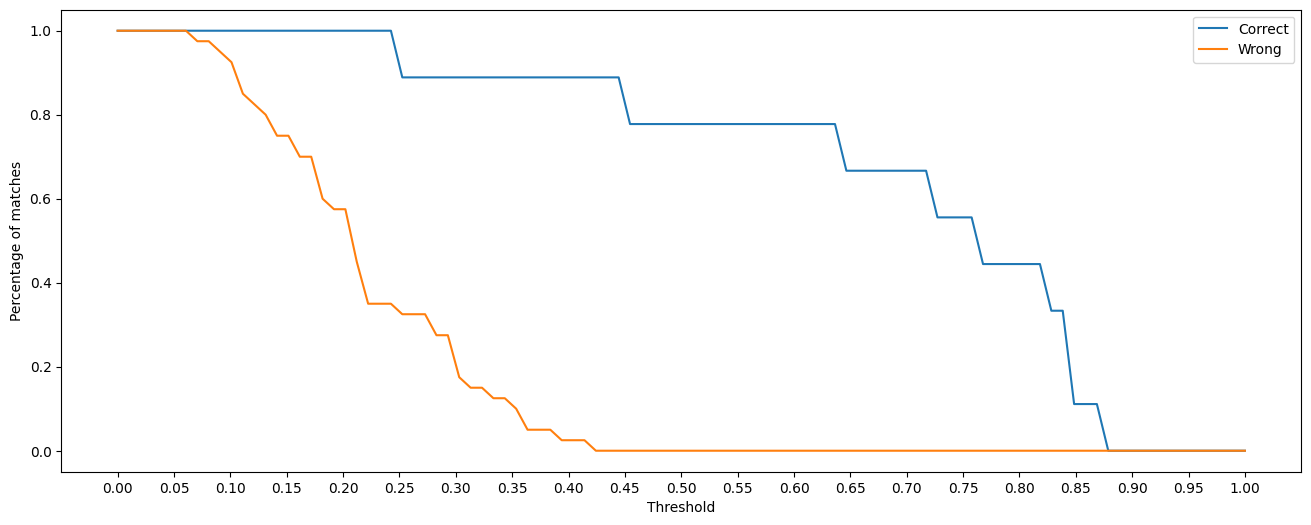

In [ ]:
# Set to 0 all the values below a threshold
def perc_filtered(confidences, threshold):
    confidences_thresholded = np.where(confidences > threshold, confidences, 0)
    # Get how many times the confidence is above the threshold, compared to the non-thresholded version
    confidences_thresholded_count = np.sum(confidences_thresholded > 0, axis=(2, 3))
    confidences_count = np.sum(confidences > 0, axis=(2, 3))

    return confidences_thresholded_count / confidences_count

thresholds = np.linspace(0, 1, 100)
res_correct = np.zeros((len(kk), len(depths), len(thresholds)))
res_wrong = np.zeros((len(kk), len(depths), len(thresholds)))

for i,threshold in enumerate(thresholds):
    res_correct[:, :, i] = perc_filtered(confidences_correct, threshold)
    res_wrong[:, :, i] = perc_filtered(confidences_wrong, threshold)
       
# PLOT THE 3RD COLUMN 
plt.figure(figsize=(16, 6))
plt.plot(thresholds, res_correct[2, 2], label="Correct")	
plt.plot(thresholds, res_wrong[2, 2], label="Wrong")
plt.legend()
plt.xlabel("Threshold")    
plt.ylabel("Percentage of matches")
plt.xticks(np.linspace(0, 1, 21))

As we can see in the plot above, we want to maximize the blue line while minimizing the orange line. A good value is $t \approx 0.43$.

In [ ]:
# Same for the wrong ones
confidences_wrong_thresholded = np.where(confidences_wrong > threshold, confidences_wrong, 0)
confidences_wrong_thresholded_count = np.sum(confidences_wrong_thresholded > 0, axis=(2, 3))
confidences_wrong_count = np.sum(confidences_wrong > 0, axis=(2, 3))

confidences_wrong_thresholded_count / confidences_wrong_count

array([[1.   , 0.825, 0.025, 0.   , 0.   ],
       [1.   , 0.825, 0.025, 0.   , 0.   ],
       [1.   , 0.825, 0.025, 0.   , 0.   ],
       [1.   , 0.825, 0.025, 0.   , 0.   ],
       [1.   , 0.825, 0.025, 0.   , 0.   ]])

In [ ]:
confidences_correct_mean = np.mean(confidences_correct, axis=(2, 3), where=confidences_correct > 0)
confidences_correct_std = np.std(confidences_correct, axis=(2, 3), where=confidences_correct > 0)

In [ ]:
confidences_correct_mean

array([[1.        , 0.91666667, 0.68718693, 0.41280581, 0.21615278],
       [1.        , 0.91666667, 0.68718693, 0.41569836, 0.22374874],
       [1.        , 0.91666667, 0.69067289, 0.42264358, 0.23235205],
       [1.        , 0.91666667, 0.69067289, 0.42482123, 0.24295893],
       [1.        , 0.91666667, 0.69067289, 0.42715095, 0.25358045]])

In [ ]:
confidences_correct_std

array([[0.        , 0.12147816, 0.20103304, 0.1624431 , 0.10811828],
       [0.        , 0.12147816, 0.20103304, 0.16480521, 0.11182634],
       [0.        , 0.12147816, 0.19987335, 0.16718069, 0.1153347 ],
       [0.        , 0.12147816, 0.19987335, 0.1681669 , 0.1204532 ],
       [0.        , 0.12147816, 0.19987335, 0.1677962 , 0.12411056]])

In [ ]:
confidences_wrong_mean = np.mean(confidences_wrong, axis=(2, 3), where=confidences_wrong > 0)
confidences_wrong_std = np.std(confidences_wrong, axis=(2, 3), where=confidences_wrong > 0)

In [ ]:
confidences_wrong_mean

array([[0.925     , 0.5609375 , 0.21593878, 0.07576384, 0.02646363],
       [0.925     , 0.5609375 , 0.21593878, 0.07619025, 0.0273938 ],
       [0.925     , 0.5609375 , 0.21714709, 0.07726126, 0.02837386],
       [0.925     , 0.5609375 , 0.21714709, 0.07749796, 0.02967245],
       [0.925     , 0.5609375 , 0.21714709, 0.07785086, 0.0310277 ]])

In [ ]:
confidences_wrong_std

array([[0.12747549, 0.17200989, 0.09025368, 0.03702508, 0.01526296],
       [0.12747549, 0.17200989, 0.09025368, 0.0373853 , 0.01575668],
       [0.12747549, 0.17200989, 0.08979852, 0.03776118, 0.0162275 ],
       [0.12747549, 0.17200989, 0.08979852, 0.03783132, 0.01683349],
       [0.12747549, 0.17200989, 0.08979852, 0.03788975, 0.01736282]])

In [ ]:
confidences_correct_mean - confidences_wrong_mean

array([[0.075     , 0.35572917, 0.47124815, 0.33704196, 0.18968915],
       [0.075     , 0.35572917, 0.47124815, 0.33950811, 0.19635494],
       [0.075     , 0.35572917, 0.4735258 , 0.34538231, 0.20397819],
       [0.075     , 0.35572917, 0.4735258 , 0.34732327, 0.21328648],
       [0.075     , 0.35572917, 0.4735258 , 0.3493001 , 0.22255275]])

In [ ]:
import pandas as pd

# Reshape confidences_correct to have one row per combination of k, depth, template, and scene
reshaped_confidences = confidences_correct.reshape(-1, len(all_templates)*len(all_scenes))

# Create a list of tuples containing k, depth, scene, template, and confidence
data = []
for i, k in enumerate(kk):
    for j, depth in enumerate(depths):
        for s_index, s in enumerate(all_scenes):
            for t_index, t in enumerate(all_templates):
                data.append((k, depth, s, t, confidences_correct[i, j, t_index, s_index]))

# Create a DataFrame from the list of tuples
df_correct = pd.DataFrame(data, columns=["k", "depth", "scene", "template", "confidence"])

# Optionally, you can set "k", "depth", "scene", and "template" as categorical variables
df_correct["k"] = pd.Categorical(df_correct["k"])
df_correct["depth"] = pd.Categorical(df_correct["depth"])
df_correct["scene"] = pd.Categorical(df_correct["scene"])
df_correct["template"] = pd.Categorical(df_correct["template"])

# Display the DataFrame
# save df to csv
df_correct.to_csv("correct.csv", index=False)

In [ ]:
import pandas as pd

# Reshape confidences_correct to have one row per combination of k, depth, template, and scene
reshaped_confidences = confidences_wrong.reshape(-1, len(all_templates)*len(all_scenes))

# Create a list of tuples containing k, depth, scene, template, and confidence
data = []
for i, k in enumerate(kk):
    for j, depth in enumerate(depths):
        for s_index, s in enumerate(all_scenes):
            for t_index, t in enumerate(all_templates):
                data.append((k, depth, s, t, confidences_wrong[i, j, t_index, s_index]))

# Create a DataFrame from the list of tuples
df_wrong = pd.DataFrame(data, columns=["k", "depth", "scene", "template", "confidence"])

# Optionally, you can set "k", "depth", "scene", and "template" as categorical variables
df_wrong["k"] = pd.Categorical(df_wrong["k"])
df_wrong["depth"] = pd.Categorical(df_wrong["depth"])
df_wrong["scene"] = pd.Categorical(df_wrong["scene"])
df_wrong["template"] = pd.Categorical(df_wrong["template"])

# Display the DataFrame
df_wrong

,k,depth,scene,template,confidence
0,2,2,scene1,ref1,0.000000
1,2,2,scene1,ref2,0.000000
2,2,2,scene1,ref3,1.000000
3,2,2,scene1,ref4,1.000000
4,2,2,scene1,ref5,1.000000
...,...,...,...,...,...
1220,6,6,scene7,ref3,0.006757
1221,6,6,scene7,ref4,0.036855
1222,6,6,scene7,ref5,0.021192
1223,6,6,scene7,ref6,0.011650


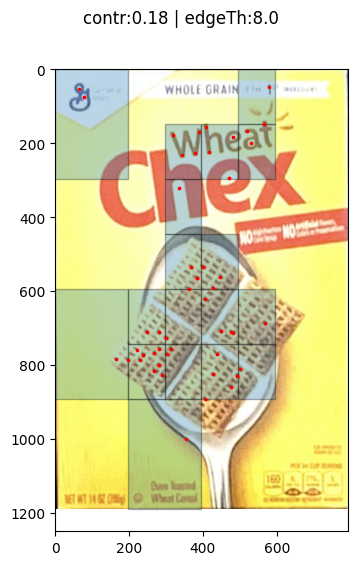

In [107]:
# Splits the given rect in 4 rect if there are at least k points inside it 
def split_rect(rect, points, k=5, max_depth=4):
    # Rect is a tuple of 4 points
    # rect = (upper_right, upper_left, lower_left, lower_right)
    rects = []
    
    y_min, y_max = rect[3][1], rect[0][1]
    x_min, x_max = rect[1][0], rect[0][0]
    y_med, x_med = (y_max + y_min)/2, (x_max + x_min)/2
    
    inside_points = [p for p in points if p[0] >= x_min and p[0] <= x_max and p[1] >= y_min and p[1] <= y_max]
    if len(inside_points) == 0:
        return None
    
    if max_depth == 0:
        return []
    
    if len(inside_points) > k:
        upper_right_rect = ((x_max, y_max), (x_med, y_max), (x_med, y_med), (x_max, y_med))
        upper_left_rect = ((x_med, y_max), (x_min, y_max), (x_min, y_med), (x_med, y_med))
        lower_left_rect = ((x_med, y_med), (x_min, y_med), (x_min, y_min), (x_med, y_min))
        lower_right_rect = ((x_max, y_med), (x_med, y_med), (x_med, y_min), ((x_max, y_min)))
                
        upper_right_split = split_rect(upper_right_rect, points, k, max_depth-1)
        upper_left_split = split_rect(upper_left_rect, points, k, max_depth-1)
        lower_left_split = split_rect(lower_left_rect, points, k, max_depth-1)
        lower_right_split = split_rect(lower_right_rect, points, k, max_depth-1)

        for s,r in [(upper_right_split, upper_right_rect), (upper_left_split, upper_left_rect), (lower_left_split, lower_left_rect), (lower_right_split, lower_right_rect)]:
            if s is not None:
                if len(s) > 0:
                    rects += s
                else:
                    rects += [r]
                    
    return rects



contrastThreshold = 0.18
edgeThreshold = 8.0

sift = cv2.SIFT_create(
    contrastThreshold = contrastThreshold,
    edgeThreshold = edgeThreshold,
    # enable_precise_upscale = True
)



template = cv2.imread("./dataset/models/ref10.png")
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)


kp_template = sift.detect(template)
kp_template, desc_template = sift.compute(template, kp_template)


h, w, _ = template.shape
rects = split_rect(
    ( (w, h), (0, h), (0, 0), (w, 0) ),
    [ (kp.pt[0], kp.pt[1]) for kp in kp_template ],
    k = 3,
    max_depth = 3
)

plt.figure(figsize=(16, 6))
plt.suptitle(f"contr:{contrastThreshold} | edgeTh:{edgeThreshold}")
ax = plt.subplot(1, 1, 1)
ax.imshow(template)
ax.plot([kp.pt[0] for kp in kp_template], [kp.pt[1] for kp in kp_template], "r.", markersize=3)
for r in rects:
    ax.add_patch(Rectangle(r[2], r[0][0] - r[1][0], r[0][1] - r[3][1], fill=True, alpha=0.3, edgecolor="black"))

plt.show()